# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

In [1]:
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import ascii

Text(0, 0.5, 'Flux [arb units]')

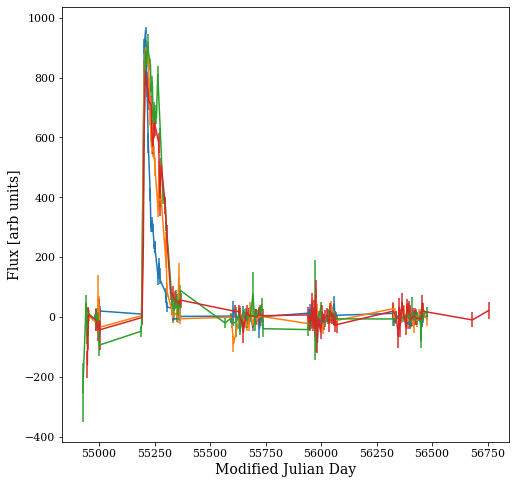

In [228]:
# let's look at 098

datafile = '098.dat'
df = pd.read_table(datafile, header=None, sep=' ', names=['Obs', 'Band', 'Nul', 'NULL', 'Flux', 'Flux_err', 'Mag', 'Mag_err'])
df = df.drop(df.index[-1])

g_curve = df.loc[df.Band == 'g', ['Obs', 'Flux', 'Flux_err']]
r_curve = df.loc[df.Band == 'r', ['Obs', 'Flux', 'Flux_err']] 
i_curve = df.loc[df.Band == 'i', ['Obs', 'Flux', 'Flux_err']] 
z_curve = df.loc[df.Band == 'z', ['Obs', 'Flux', 'Flux_err']] 

plt.figure(figsize=[8,8])
plt.errorbar(g_curve.Obs, g_curve.Flux, yerr=g_curve.Flux_err)
plt.errorbar(r_curve.Obs, r_curve.Flux, yerr=r_curve.Flux_err)
plt.errorbar(i_curve.Obs, i_curve.Flux, yerr=i_curve.Flux_err)
plt.errorbar(z_curve.Obs, z_curve.Flux, yerr=z_curve.Flux_err)
plt.xlabel('Modified Julian Day')
plt.ylabel('Flux [arb units]')

Text(0, 0.5, 'Flux [arb units]')

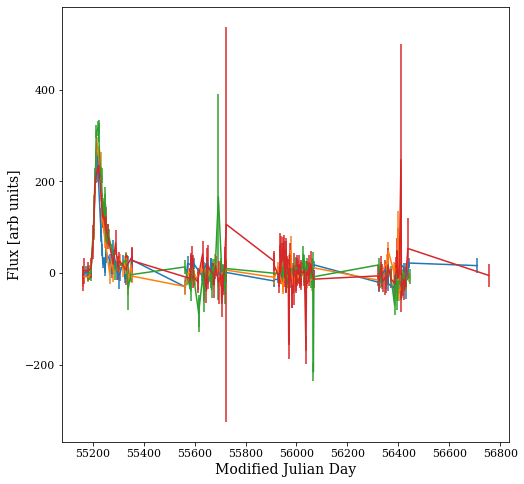

In [197]:
# let's look at 174 now

datafile = '174.dat'
df = pd.read_table(datafile, header=None, sep=' ', names=['Obs', 'Band', 'Nul', 'NULL', 'Flux', 'Flux_err', 'Mag', 'Mag_err'])
df = df.drop(df.index[-1])
    
g_curve = df.loc[df.Band == 'g', ['Obs', 'Flux', 'Flux_err']]
r_curve = df.loc[df.Band == 'r', ['Obs', 'Flux', 'Flux_err']] 
i_curve = df.loc[df.Band == 'i', ['Obs', 'Flux', 'Flux_err']] 
z_curve = df.loc[df.Band == 'z', ['Obs', 'Flux', 'Flux_err']] 
    
plt.figure(figsize=[8,8])
plt.errorbar(g_curve.Obs, g_curve.Flux, yerr=g_curve.Flux_err)
plt.errorbar(r_curve.Obs, r_curve.Flux, yerr=r_curve.Flux_err)
plt.errorbar(i_curve.Obs, i_curve.Flux, yerr=i_curve.Flux_err)
plt.errorbar(z_curve.Obs, z_curve.Flux, yerr=z_curve.Flux_err)
plt.xlabel('Modified Julian Day')
plt.ylabel('Flux [arb units]')
    

In [118]:
# I will use chi squared metric for this MCMC stuff

def chiSq(data, model, error):
    
    chi = np.sum(((data - model) / error)**2)
    
    return chi

def model(A, beta, t0, gamma, t_rise, t_fall, t): 
    
    t1 = gamma + t0
    
    for i in range(len(t)):
        
        if t[i] < t1:
            flux = (A + (beta * (t - t0))) / (1 + np.exp(-(t - t0) / t_rise))
            
            return flux
        
        else:
            flux = (A + (beta * (gamma))) * np.exp(- (t - t1) / t_fall) / (1 + np.exp(-(t - t0) / t_rise))
            
            return flux

In [196]:
# now build the mcmc code

import emcee
import sys
import os
import shutil

import time
start = time.time()

def lnprob(p0):
    
    A, beta, t0, gamma, t_rise, t_fall = p0
    
    priors_A = [500, 100000]
    priors_beta = [-5, 0]
    priors_t0 = [54500, 57000]
    priors_gamma = [1, 20]
    priors_t_rise = [0.01, 50]
    priors_t_fall = [1, 300]
    
    if A < priors_A[0] or A > priors_A[1]:
        #print('A out of bounds')
        return -np.inf
    
    if beta < priors_beta[0] or beta > priors_beta[1]:
        #print('beta out of bounds')
        return -np.inf
    
    if t0 < priors_t0[0] or t0 > priors_t0[1]:
        #print('t0 out of bounds')
        return -np.inf
    
    if gamma < priors_gamma[0] or gamma > priors_gamma[1]:
        #print('t1 out of bounds')
        return -np.inf
    
    if t_rise < priors_t_rise[0] or t_rise > priors_t_rise[1]:
        #print('t_rise out of bounds')
        return -np.inf
    
    if t_fall < priors_t_fall[0] or t_fall > priors_t_fall[1]:
        #print('t_fall out of bounds')
        return -np.inf
    
    chi_g = chiSq(g_curve.Flux, model(A, beta, t0, gamma, t_rise, t_fall, t=g_curve.Obs), error=g_curve.Flux_err)
    chi_r = chiSq(r_curve.Flux, model(A, beta, t0, gamma, t_rise, t_fall, t=r_curve.Obs), r_curve.Flux_err)
    chi_i = chiSq(i_curve.Flux, model(A, beta, t0, gamma, t_rise, t_fall, t=i_curve.Obs), i_curve.Flux_err)
    chi_z = chiSq(z_curve.Flux, model(A, beta, t0, gamma, t_rise, t_fall, t=z_curve.Obs), z_curve.Flux_err)

    return (chi_g + chi_r + chi_i + chi_z) * -0.5
    
# now define model per equation 1
    
def MCMC(nsteps=5000, ndim=6, nwalkers=20, param_1 = 1000, param_2 = -2, param_3 = 55000, param_4 = 10, 
         param_5 = 10, param_6 = 100, sigma_1 = 10, sigma_2 = 0.5, sigma_3 = 10, sigma_4 = 2, sigma_5 = 2, sigma_6 = 10):
    
    p0 = np.random.normal(loc=(param_1, param_2, param_3, param_4, param_5, param_6), size=(nwalkers, ndim), 
                          scale=(sigma_1, sigma_2, sigma_3, sigma_4, sigma_5, sigma_6))
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
    run = sampler.sample(p0, iterations=nsteps, store=True)
    steps = []
    
    for i, result in enumerate(run):
        pos, lnprobs, blob = result
        
        new_step = [np.append(pos[k], lnprobs[k]) for k in range(nwalkers)]
        steps += new_step
        df = pd.DataFrame(steps)
        df.columns = ['A', 'beta', 't0', 'gamma', 't_rise', 't_fall', 'lnprobs']
        df.to_csv('503_HW3_MCMC_174.csv', mode='w')
        sys.stdout.write('completed step {} out of {} \r'.format(i, nsteps) )
        sys.stdout.flush()
        
    print('Finished MCMC')
    print('Mean acceptance fraction: {0:3f}'.format(np.mean(sampler.acceptance_fraction)))
    print('Elapsed time (mins):' , (time.time() - start)/60)

In [181]:
MCMC(nsteps=3000)

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Finished MCMCp 2999 out of 3000 
Mean acceptance fraction: 0.264533
Elapsed time (mins): 169.05696578025817


In [189]:
# function for walker plots -- how do our chains look?

nwalkers = 20
burnin = 500
csvfile = '503_HW3_MCMC_098.csv'
skiprows = nwalkers * burnin

walkers = pd.read_csv(csvfile)
walkers = walkers.drop(walkers.index[0:skiprows])

def walker_plot(arr, nwalkers=20):

        steps = len(arr) / nwalkers

        plt.figure(figsize=(12,4))

        for n in range(nwalkers):
            w_n = arr[n::nwalkers]
            plt.plot(range(int(steps)), w_n)

        plt.xlabel('steps')
        plt.ylabel(str(arr.name))
        plt.show()

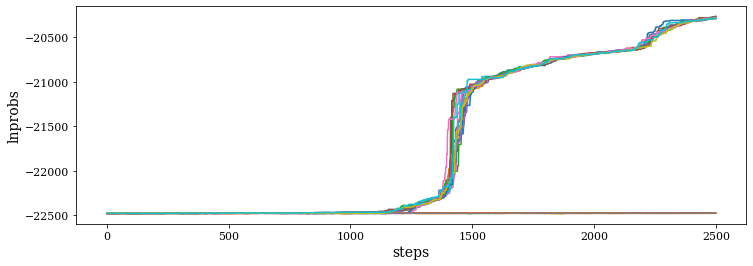

In [190]:
# for example...

walker_plot(walkers.lnprobs)

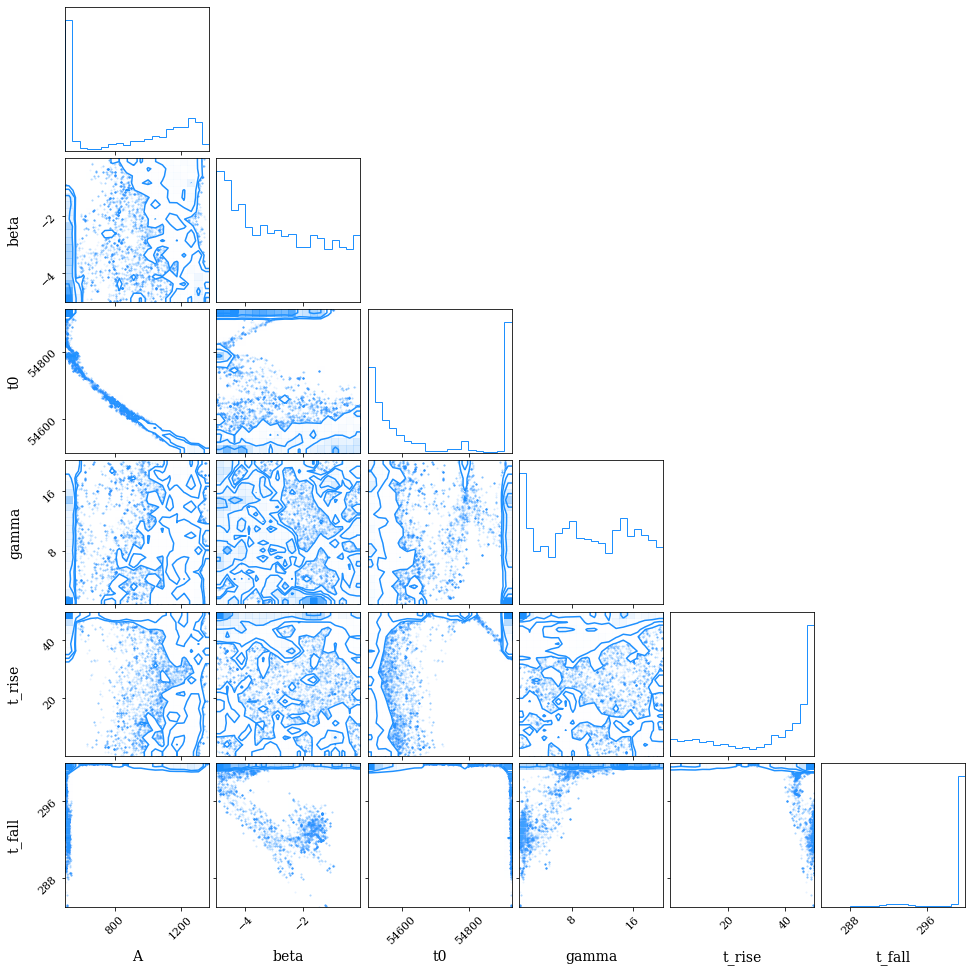

In [191]:
# 10 pts -- make a corner plot

import corner
import matplotlib as mpl

params = {'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'font.family': 'serif',
          'axes.labelsize': 14
          }

mpl.rcParams.update(params)

#plotting function

def corner_plot(csvfile, skiprows):

    df = pd.read_csv(csvfile)
    df = df.drop(axis=1, labels='Unnamed: 0')
    df = df.drop(axis=1, labels='lnprobs')
    df = df.drop(df.index[0:skiprows])

    fig = corner.corner(df, color='dodgerblue', max_n_ticks=2)

# corner plot for 098
    
corner_plot(csvfile, skiprows)

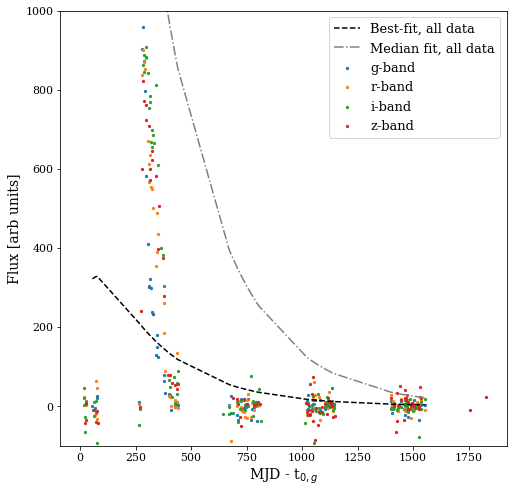

In [236]:
# plot the best-fit model to the data (25 points)

# I'm making a slightly different version of VAV's plot, showing the median fit like she did, 
# but rather than draw five random ones for a sense of uncertainties I'll just plot the best-fit
# from my posteriors. For 098, the best fit would in reality lie right between my median and my
# best-fit model light curves. Perhaps with more steps I'd get closer to the best answer here
# but this will have to do for now. 

nwalkers = 20
burnin = 1000
data_098 = '503_HW3_MCMC_098.csv'
skiprows = nwalkers * burnin

datafile = '098.dat'
df = pd.read_table(datafile, header=None, sep=' ', names=['Obs', 'Band', 'Nul', 'NULL', 'Flux', 'Flux_err', 'Mag', 'Mag_err'])
df = df.drop(df.index[-1])

g_curve = df.loc[df.Band == 'g', ['Obs', 'Flux', 'Flux_err']]
r_curve = df.loc[df.Band == 'r', ['Obs', 'Flux', 'Flux_err']] 
i_curve = df.loc[df.Band == 'i', ['Obs', 'Flux', 'Flux_err']] 
z_curve = df.loc[df.Band == 'z', ['Obs', 'Flux', 'Flux_err']] 

walkers = pd.read_csv(data_098)
walkers = walkers.drop(walkers.index[0:skiprows])
index = walkers.lnprobs.idxmax()

A_bf = walkers.A[index]
beta_bf = walkers.beta[index]
t0_bf = walkers.t0[index]
gamma_bf = walkers.gamma[index]
t_rise_bf = walkers.t_rise[index]
t_fall_bf = walkers.t_fall[index]

plt.figure(figsize=[8,8])
plt.plot(g_curve.Obs - t0_bf, model(A_bf, beta_bf, t0_bf, gamma_bf, t_rise_bf, t_fall_bf, g_curve.Obs), 
         color='black', linestyle='--', label='Best-fit, all data')
plt.plot(g_curve.Obs - t0_bf, model(np.median(walkers.A), np.median(walkers.A), np.median(walkers.t0), 
                            np.median(walkers.gamma), np.median(walkers.t_rise), 
                            np.median(walkers.t_fall), g_curve.Obs), 
         color='grey', linestyle='-.', label='Median fit, all data')
plt.scatter(g_curve.Obs - t0_bf, g_curve.Flux, s=5, label='g-band')
plt.scatter(r_curve.Obs - t0_bf, r_curve.Flux, s=5, label='r-band')
plt.scatter(i_curve.Obs - t0_bf, i_curve.Flux, s=5, label='i-band')
plt.scatter(z_curve.Obs - t0_bf, z_curve.Flux, s=5, label='z-band')
plt.xlabel(r'MJD - t$_{0, g}$')
plt.ylabel('Flux [arb units]')
plt.ylim(-100, 1000)
plt.legend(loc='upper right', fontsize=13)
plt.show()

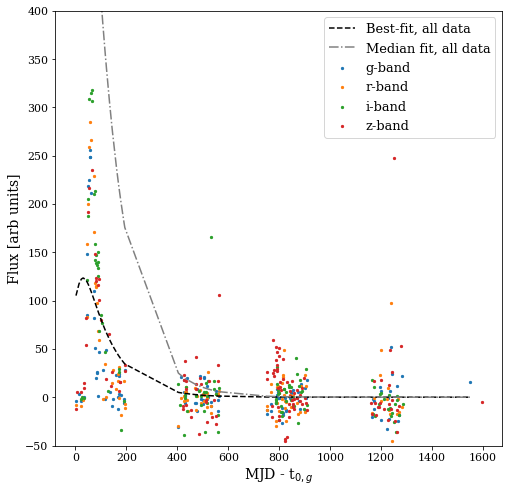

In [235]:
# now for object 174, here's my version of VAV's plot.

nwalkers = 20
burnin = 1000
data_174 = '503_HW3_MCMC_174.csv'
skiprows = nwalkers * burnin

datafile = '174.dat'
df = pd.read_table(datafile, header=None, sep=' ', names=['Obs', 'Band', 'Nul', 'NULL', 'Flux', 'Flux_err', 'Mag', 'Mag_err'])
df = df.drop(df.index[-1])

g_curve = df.loc[df.Band == 'g', ['Obs', 'Flux', 'Flux_err']]
r_curve = df.loc[df.Band == 'r', ['Obs', 'Flux', 'Flux_err']] 
i_curve = df.loc[df.Band == 'i', ['Obs', 'Flux', 'Flux_err']] 
z_curve = df.loc[df.Band == 'z', ['Obs', 'Flux', 'Flux_err']] 

walkers = pd.read_csv(data_174)
walkers = walkers.drop(walkers.index[0:skiprows])
index = walkers.lnprobs.idxmax()

A_bf = walkers.A[index]
beta_bf = walkers.beta[index]
t0_bf = walkers.t0[index]
gamma_bf = walkers.gamma[index]
t_rise_bf = walkers.t_rise[index]
t_fall_bf = walkers.t_fall[index]

plt.figure(figsize=[8,8])
plt.plot(g_curve.Obs - t0_bf, model(A_bf, beta_bf, t0_bf, gamma_bf, t_rise_bf, t_fall_bf, g_curve.Obs), 
         color='black', linestyle='--', label='Best-fit, all data')
plt.plot(g_curve.Obs - t0_bf, model(np.median(walkers.A), np.median(walkers.A), np.median(walkers.t0), 
                            np.median(walkers.gamma), np.median(walkers.t_rise), 
                            np.median(walkers.t_fall), g_curve.Obs), 
         color='grey', linestyle='-.', label='Median fit, all data')
plt.scatter(g_curve.Obs - t0_bf, g_curve.Flux, s=5, label='g-band')
plt.scatter(r_curve.Obs - t0_bf, r_curve.Flux, s=5, label='r-band')
plt.scatter(i_curve.Obs - t0_bf, i_curve.Flux, s=5, label='i-band')
plt.scatter(z_curve.Obs - t0_bf, z_curve.Flux, s=5, label='z-band')
plt.xlabel(r'MJD - t$_{0, g}$')
plt.ylabel('Flux [arb units]')
plt.ylim(-50, 400)
plt.legend(loc='upper right', fontsize=13)
plt.show()

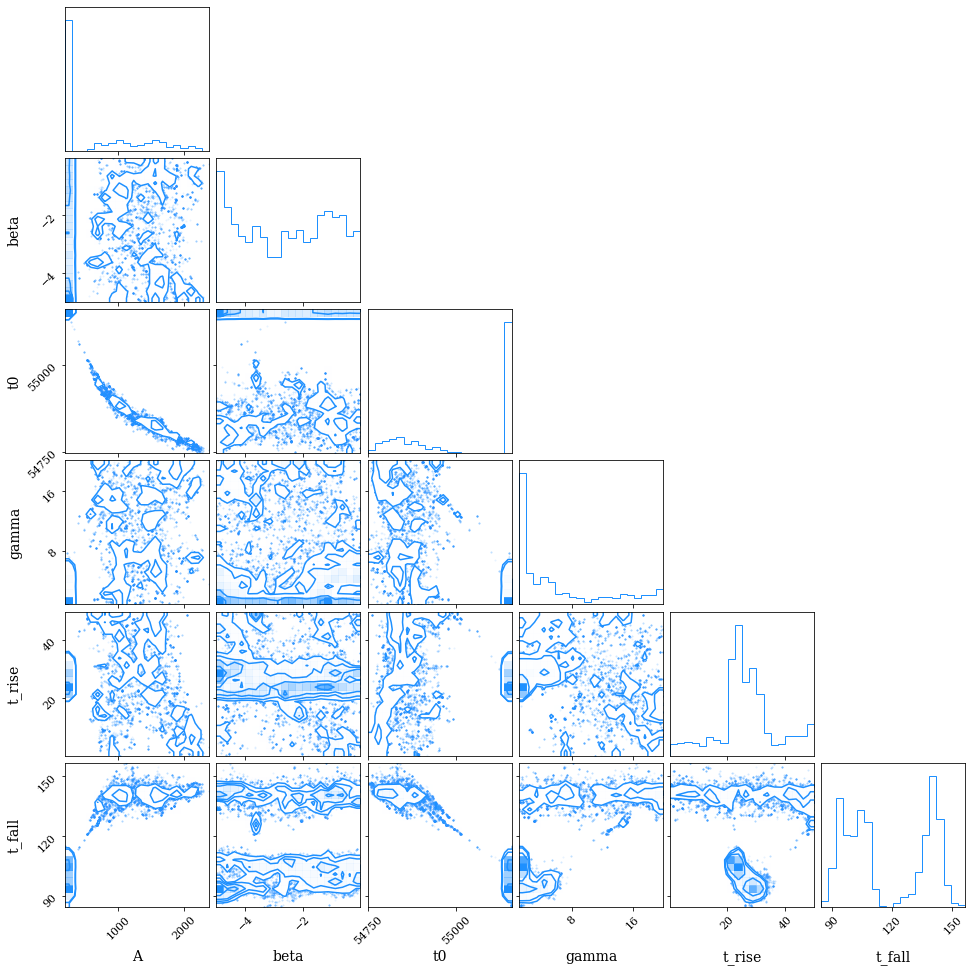

In [292]:
# corner plot for 174

corner_plot(data_174, skiprows)

In [291]:
# finally, the autocorrelation length of the chain...

from emcee.autocorr import integrated_time

df = pd.read_csv('503_HW3_MCMC_098.csv')

# Extract the parameter columns into a numpy array
params = df[['A', 'beta', 't0', 'gamma', 't_rise', 't_fall']].to_numpy()

# Define the number of walkers and steps
nwalkers = 20
nsteps = 3000
nchains = 6

params = np.transpose(params.reshape((nchains, nwalkers, nsteps)), (2, 1, 0))

tau = emcee.autocorr.integrated_time(params[:, nwalkers, nsteps])

# this isn't working :( and I dont have enough time to finish

plt.figure(figsize=[12,12])
plt.plot(np.mean(tau, axis=1))
plt.xlabel('Parameter index')
plt.ylabel('Integrated autocorrelation time')
plt.show()

IndexError: index 20 is out of bounds for axis 1 with size 20